In [1]:
import sys
sys.path.insert(1, '../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm
from skmisc.loess import loess
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from agingml import continuous_retraining_test as crt
from agingml import temporal_degradation_test as tdt

/Users/santiago/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
# Experiment set up
dataset = 'taxi'
min_n_train = 8800 # one year
n_test = 2200
n_prod = 4400
n_simulations = 1500
n_retrainings = 3
metric = mean_absolute_percentage_error
freq = 'D'
models = ['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor']

### Plot Error

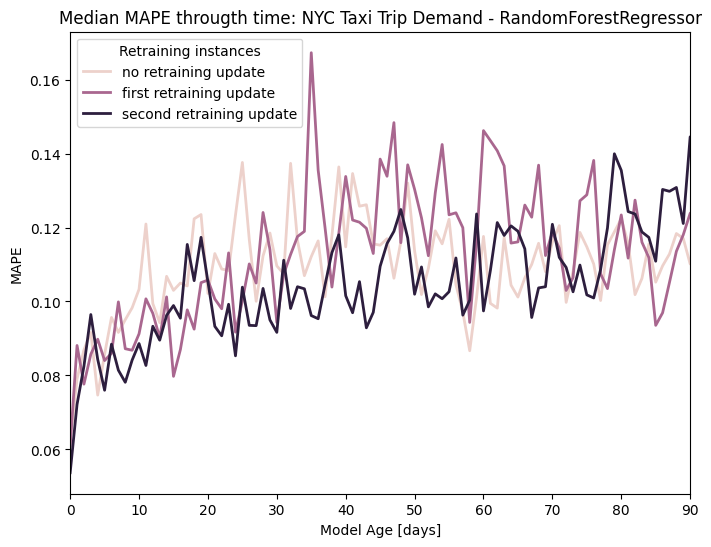

In [64]:
for model in models:


        errors_df = pd.read_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
        # d_errors_df = crt.aggregate_errors_data(errors_df, metric=metric, freq=freq, only_valid_models=True)
        # d_errors_df.to_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')
        
        # d_errors_df.to_parquet(f'../results/retraining/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')
        d_errors_df = pd.read_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

        errors_df = errors_df[errors_df['model_age'] <= 800]
        d_errors_df = d_errors_df[d_errors_df['model_age'] <= 800]
        test_errors_df = errors_df[(errors_df['partition'] == 'test') & (errors_df['retraining_id'] == 0)]
        test_mape = test_errors_df.groupby('simulation_id').apply(lambda group: mean_absolute_percentage_error(group.y, group.y_pred))
        test_mape = pd.DataFrame(test_mape, columns=['test_mape']).reset_index()

        d_errors_df = pd.merge(d_errors_df, test_mape, how='left', on='simulation_id')
        d_errors_df = d_errors_df[d_errors_df['test_mape'] <= 0.1]
        
        df = d_errors_df[d_errors_df['partition'] == 'prod']
        df = df.groupby(['partition', 'retraining_id', 'model_age'])['error'].agg(lambda x: x.quantile([0.5])).rename('error').reset_index() 


        fig, ax = plt.subplots(figsize=(8, 6))
        sns.lineplot(data=df, x='model_age', y='error', hue='retraining_id', linewidth=2.0)
        plt.legend(title="Retraining instances",
                labelcolor='linecolor',
                labels=['no retraining update', 'first retraining update','second retraining update'],
                loc="upper left")
        plt.xlim(0, 90)
        

        plt.xlabel('Model Age [days]')
        plt.ylabel('MAPE')
        plt.title(f'Median MAPE througth time: NYC Taxi Trip Demand - {model}')

        plt.show()
        fig.savefig(f'../figures/retraining/{dataset}/continuous_retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.svg', format='svg')
